In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로딩
df = pd.read_csv("student-mat.csv", sep=";")

# 데이터 크기 확인
data_shape = df.shape
print(data_shape)
print(df.head())

# 숫자형 변수
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numeric Columns ({}개):".format(len(numeric_cols)))
print(", ".join(numeric_cols))

# 범주형 변수
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
print(" Categorical Columns ({}개):".format(len(categorical_cols)))
print(", ".join(categorical_cols))



# one-hot encoding (첫 번째 레벨 제거: drop_first=True)
#df_encoded = pd.get_dummies(df, drop_first=True)

#data_shape, categorical_cols, df_encoded.shape


(395, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
Numeric Columns (16개):
age, Medu, Fedu, traveltime, studytime, failures, famre

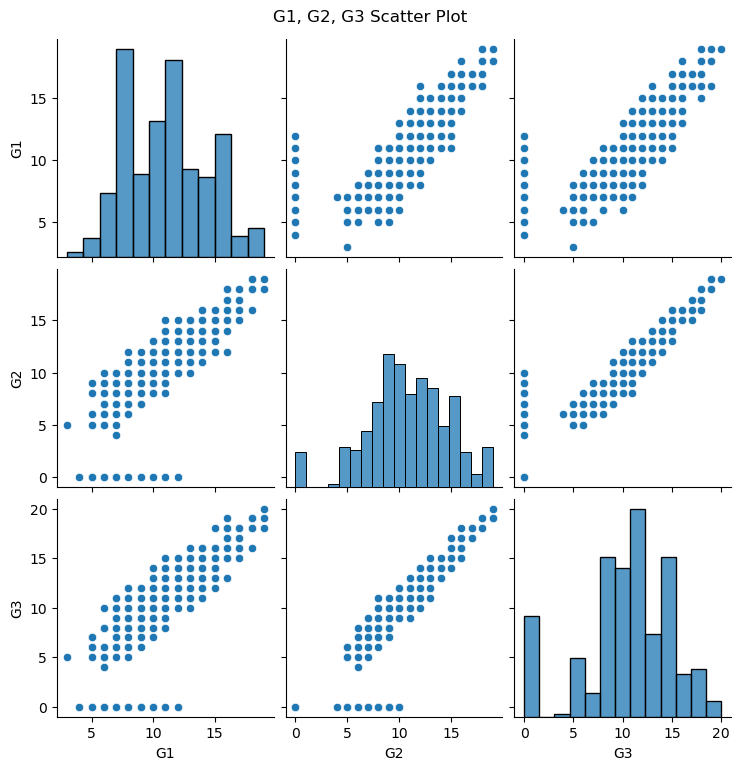

,G1,G2,G3
G1,1.000000,0.852118,0.801468
G2,0.852118,1.000000,0.904868
G3,0.801468,0.904868,1.000000


In [13]:
# G1, G2, G3만 추출
grades = df[["G1", "G2", "G3"]]

# 상관행렬 계산
correlation_matrix = grades.corr()

# Scatter plot
sns.pairplot(grades)
plt.suptitle("G1, G2, G3 Scatter Plot", y=1.02)
plt.show()

correlation_matrix


In [17]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

# G2, G3 제거 / G1을 타겟으로 설정
df_g1 = df.drop(columns=["G2", "G3"])
target = "G1"

# 범주형 변수 처리
df_g1_encoded = pd.get_dummies(df_g1, drop_first=True)

# 학습/테스트 분할
train_df, test_df = train_test_split(df_g1_encoded, test_size=0.2, random_state=42)

# Stepwise selection 함수 재정의
def stepwise_selection(data, target, direction='both'):
    remaining = list(data.columns)
    remaining.remove(target)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    
    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(target, ' + '.join(selected + [candidate]))
            model = smf.ols(formula, data=data).fit()
            aic = model.aic
            scores_with_candidates.append((aic, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break

    final_formula = "{} ~ {}".format(target, ' + '.join(selected))
    final_model = smf.ols(final_formula, data=data).fit()
    return final_model, final_formula

# Stepwise 모델 적합
step_model_g1, step_formula_g1 = stepwise_selection(train_df, target)

# 최종 모형 식 출력
step_formula_g1


'G1 ~ failures + schoolsup_yes + studytime + Fjob_teacher + famsup_yes + Mjob_health + Mjob_services + higher_yes + sex_M + goout + freetime + health + famsize_LE3'

In [18]:
#!pip install statsmodels

In [19]:
# 최종 회귀모형의 계수 요약 (statsmodels summary 출력)
step_model_g1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     11.58
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           2.89e-20
Time:                        14:47:17   Log-Likelihood:                -753.21
No. Observations:                 316   AIC:                             1534.
Df Residuals:                     302   BIC:                             1587.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.6790      1.068      8.130      0.000       6.578      10.780
failures         -1.2915      0.221     -5.843      0.000      -1.727      -0.857
schoolsup_yes    -2.2238      0.448     -4.961      0.000      -3.106      -1.342
studytime         0.8734      0.197      4.423      0.000       0.485       1.262
Fjob_teacher      2.0751      0.617      3.364      0.001       0.861       3.289
famsup_yes       -1.0467      0.326     -3.213      0.001      -1.688      -0.406
Mjob_health       1.9321      0.561      3.444      0.001       0.828       3.036
Mjob_services     1.1807      0.352      3.352      0.001       0.488       1.874
higher_yes        1.7956      0.703      2.553      0.011       0.412       3.180
sex_M             0.7140      0.339      2.109      0.036       0.048       1.380
goout            -0.4085      0.146     -2.789      0.006      -0.697      -0.120
freetime          0.3086      0.163      1.892      0.059      -0.012       0.630
health           -0.1814      0.110     -1.655      0.099      -0.397       0.034
famsize_LE3       0.4866      0.340      1.431      0.153      -0.182       1.156
==============================================================================
Omnibus:                        3.557   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.164
Skew:                           0.166   Prob(JB):                        0.206
Kurtosis:                       2.639   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Categorical 변수중에 특정 레벨만 선택이 되고 나머지는 선택이 되지 않았을때 어떻게 해석하는가?

어떤 관측치의 그 변수의 레벨이 모형에서 선택되지 않았으면 그 변수의 회귀계수가 0이라고 해석한다.

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# train 데이터에서 예측값 계산
y_train_true = train_df["G1"]
y_train_pred = step_model_g1.predict(train_df)

# RMSE 계산
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
rmse_train


2.6238056088694024

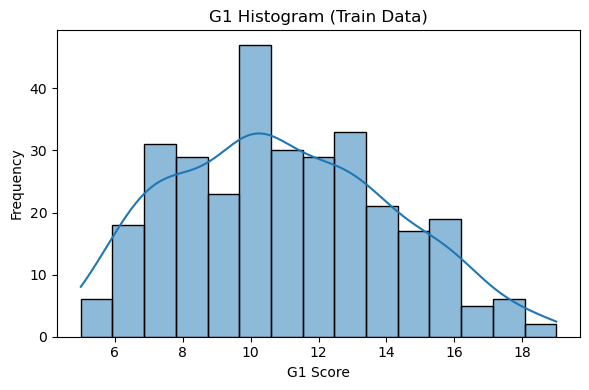

min     5.0
25%     8.0
50%    11.0
75%    13.0
max    19.0
Name: G1, dtype: float64

In [22]:
import matplotlib.pyplot as plt

# G1 히스토그램
plt.figure(figsize=(6, 4))
sns.histplot(train_df["G1"], bins=15, kde=True)
plt.title("G1 Histogram (Train Data)")
plt.xlabel("G1 Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5-number summary
g1_summary = train_df["G1"].describe()[["min", "25%", "50%", "75%", "max"]]
g1_summary


In [23]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# X, y 정의
X_train = train_df.drop(columns=["G1"])
y_train = train_df["G1"]

# 랜덤 포레스트 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# 랜덤 포레스트 + 그리드 서치 (CV)
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 모형 및 파라미터
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_

best_params, best_cv_score


({'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100},
 8.709301592917274)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
# 최적 파라미터를 직접 입력하거나 GridSearch 결과로부터 설정

best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5
}


# 모델 적합
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# 예측
y_train_pred = best_rf_model.predict(X_train)

# 성능 평가
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"🔍 Train R-squared: {train_r2:.4f}")
print(f"🔍 Train RMSE: {train_rmse:.4f}")

🔍 Train R-squared: 0.7943
🔍 Train RMSE: 1.4566


In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 특성, 타겟
X_train = train_df.drop(columns=["G1"])
y_train = train_df["G1"]

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

# Gradient Boosting 모델 + GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 모델 및 CV 성능
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_rmse = (-grid_search.best_score_) ** 0.5

print("📌 Best Parameters:", best_params)
print(f"📉 Best CV RMSE: {best_cv_rmse:.4f}")

# Train set에서 재적합 후 평가
y_train_pred = best_gbr_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"\n✅ Train R-squared: {train_r2:.4f}")
print(f"✅ Train RMSE: {train_rmse:.4f}")


📌 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
📉 Best CV RMSE: 3.0304

✅ Train R-squared: 0.6135
✅ Train RMSE: 1.9967


In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 특성, 타겟
X_train = train_df.drop(columns=["G1"])
y_train = train_df["G1"]

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# XGBoost 모델 + GridSearchCV
xgb = XGBRegressor(random_state=42, verbosity=0)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 모델 및 성능
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_rmse = (-grid_search.best_score_) ** 0.5

print("📌 Best Parameters:", best_params)
print(f"📉 Best CV RMSE: {best_cv_rmse:.4f}")

# Train에서 재적합 후 평가
y_train_pred = best_xgb_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"\n✅ Train R-squared: {train_r2:.4f}")
print(f"✅ Train RMSE: {train_rmse:.4f}")


📌 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
📉 Best CV RMSE: 2.9714

✅ Train R-squared: 0.6096
✅ Train RMSE: 2.0068


In [28]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. 데이터 준비
X_test = test_df.drop(columns=["G1"])
y_test = test_df["G1"]

# 2. 각 모델 예측값
y_pred_lin = step_model_g1.predict(test_df)                          # statsmodels는 DataFrame 사용
y_pred_rf = best_rf_model.predict(X_test)
y_pred_gbr = best_gbr_model.predict(X_test)
y_pred_xgb = best_xgb_model.predict(X_test)

# 3. 성능 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# 4. 평가 결과 저장
results = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "XGBoost"],
    "RMSE": [],
    "R-squared": []
}

for y_pred in [y_pred_lin, y_pred_rf, y_pred_gbr, y_pred_xgb]:
    rmse, r2 = evaluate_model(y_test, y_pred)
    results["RMSE"].append(rmse)
    results["R-squared"].append(r2)

# 5. 결과 정리
results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE", ascending=True, inplace=True)

print("📊 Test Set Performance (Best Model = RMSE 최소):")
print(results_df.to_string(index=False))


📊 Test Set Performance (Best Model = RMSE 최소):
            Model     RMSE  R-squared
          XGBoost 3.186130   0.257546
    Random Forest 3.284797   0.210850
Linear Regression 3.292411   0.207188
Gradient Boosting 3.335086   0.186502


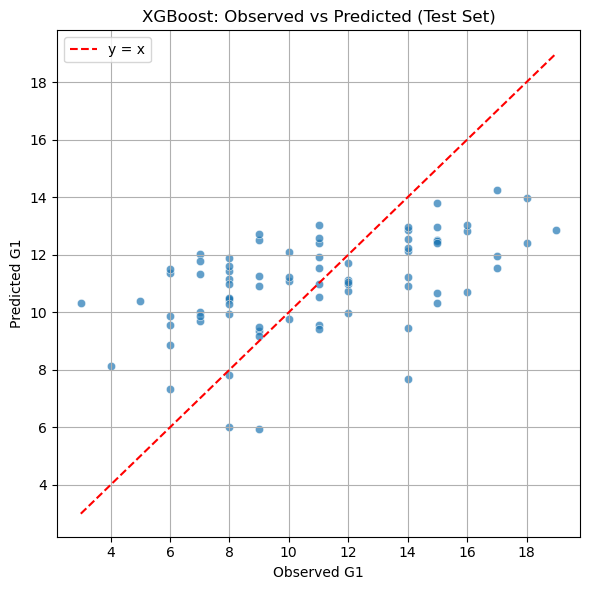

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값 vs 실제값
y_true = y_test
y_pred = y_pred_xgb

# 산점도 그리기
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label='y = x')
plt.xlabel("Observed G1")
plt.ylabel("Predicted G1")
plt.title("XGBoost: Observed vs Predicted (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

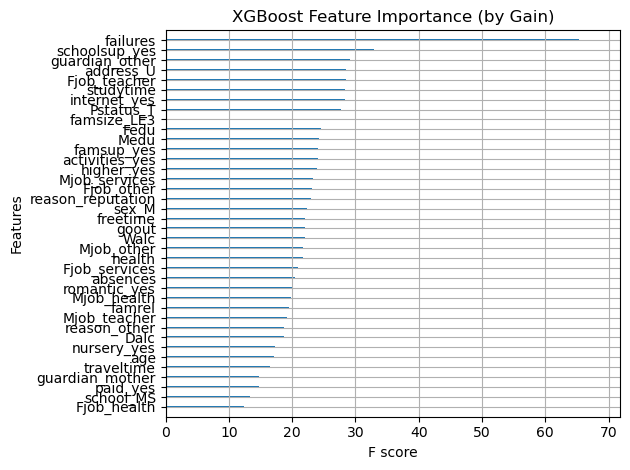

In [31]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(best_xgb_model, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()


Top 2 Important Features: ['failures', 'schoolsup_yes']


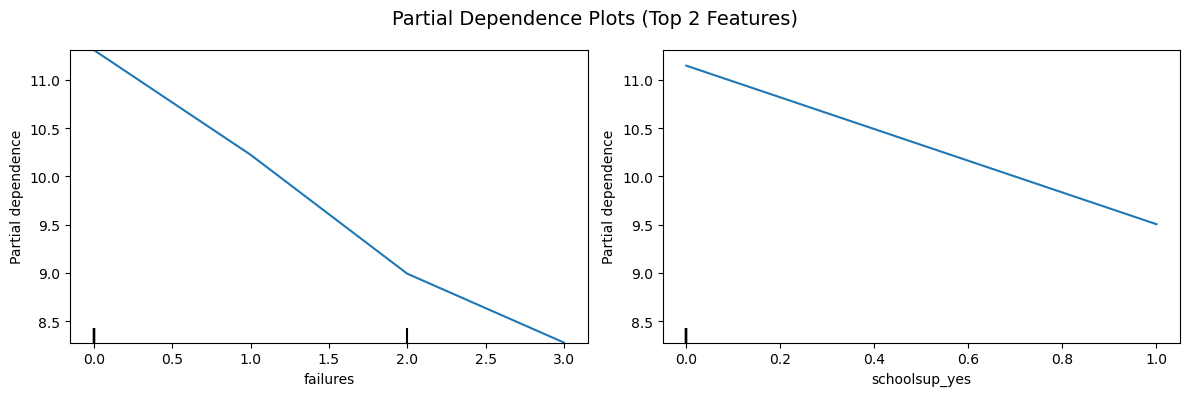

In [34]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1. 변수 중요도 기준 상위 2개 feature 추출
import numpy as np

feature_importances = best_xgb_model.feature_importances_
top2_indices = np.argsort(feature_importances)[-2:][::-1]
top2_features = X_test.columns[top2_indices].tolist()

print("Top 2 Important Features:", top2_features)

# 2. PDP 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(best_xgb_model, X_test, features=top2_features, ax=ax)
plt.suptitle("Partial Dependence Plots (Top 2 Features)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
#failure 변수는 낙제과목 수
#schoolsup yes=보충수업

<AxesSubplot: xlabel='failures', ylabel='G1'>

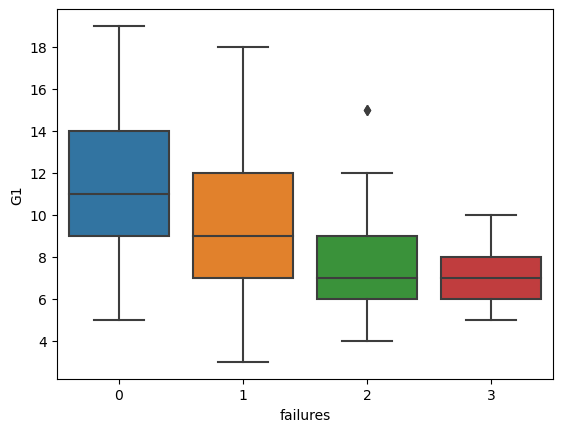

In [36]:
sns.boxplot(x="failures", y="G1", data=df)

<AxesSubplot: xlabel='schoolsup', ylabel='G1'>

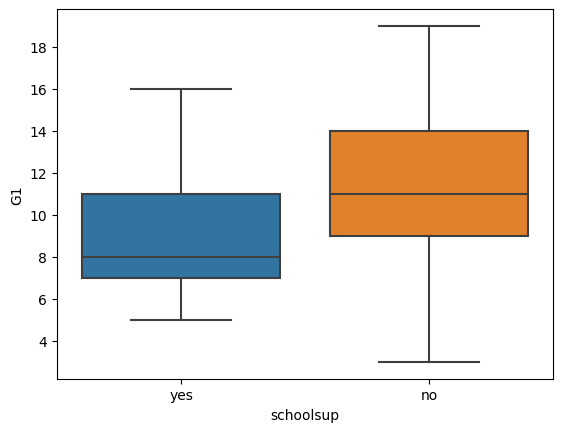

In [35]:
sns.boxplot(x="schoolsup", y="G1", data=df)
